# Overview
This notebook is a step by step guide using Snowpark and Stream to handle Change Data Capture(insert, update and delete). 

The intention of this notebook is to breakdown logic to 7 steps, so you can easily see the results in each step and debug your code if necessary. It has logic that is not required to be deployed.

Prerequisite:
1. Have snowpark and other required python libraries installed on client machine's python environment(at the moment only Python 3.8 is supported). If not, please refer to the below link for installtion details. 
https://quickstarts.snowflake.com/guide/getting_started_with_snowpark_for_python_streamlit/index.html?index=..%2F..index#1
2. Have a Snowflake account that you have privilege to create a database.
3. Already ran setup.sql script in a snowflake work sheet and necessary tables and streams are created. 
3. Please create a credentials.json file looks like below, and place this json file in same directory of  this notebook. You need replace values with your Snowflake credentials.

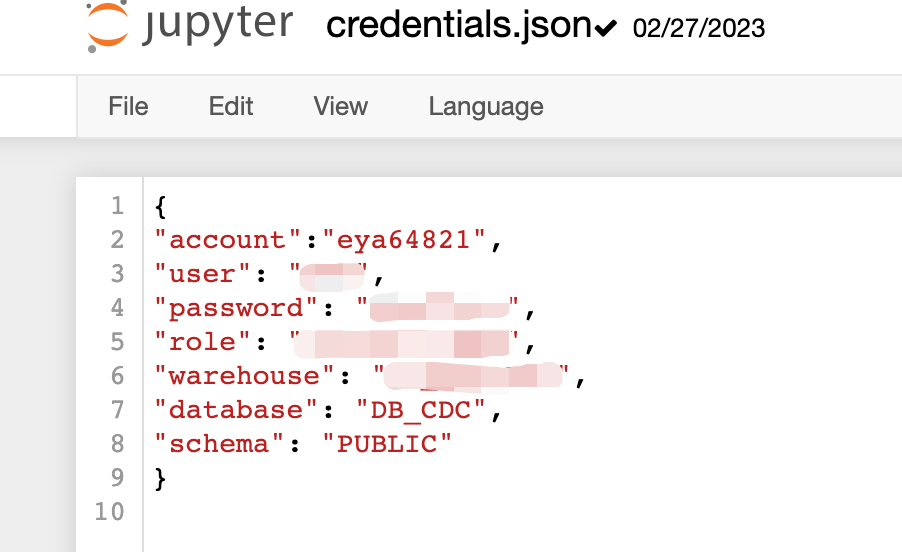


## Step 1  Import neccessary python libraries.

**Note:** if you get an error, its likely you didn't install required library.

**Expected Resut:** You should not see any error messages.

In [55]:
# Snowpark libariary
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F

#connection credentials are saved in a credential.json file.
import json

## Step 2  Create a Snowpark Connection.

**Note:** If you get an error, please double check your snowflake credentials in credentals.json file.

**Expected Resut:** You should see your Schema, Role and Warehouse details.

In [56]:
with open('credentials.json') as f:
    connection_parameters = json.load(f)
session = Session.builder.configs(connection_parameters).create()    
print(f"Current schema: {session.get_fully_qualified_current_schema()}, current role: {session.get_current_role()}, current warehouse:  {session.get_current_warehouse()}")


Current schema: "DB_CDC"."PUBLIC", current role: "DBA_CITIBIKE", current warehouse:  "WH_XSMALL1"


## Step 3  Read columns from Stream STM_SITE.

**Note:** STM_SITE contains all changes from STG_SITE, which is the source table.

**Expected Resut:** You should see 7 columns printed out, ID, ACCT_ID, SITE_TYPE, ADDRESS and 3 NETADATA$ columns.

In [57]:
#Read data from stream table STM_SITE, the requirement here is we only need toprocess BILL_TO records into DIM_ACCT.
df_source=session.table('STM_SITE')
df_source=df_source.filter(df_source.SITE_TYPE == 'BILL_TO') 
    
#Get all column names from df_source and put them into a python list
list_schema=df_source.schema.names 

#Print all all column names, as you can see there two types of columns in a stream table. Metadata columns, and columns from source table STG_SITE.
for c in list_schema:
    print(c)          
    

ID
ACCT_ID
SITE_TYPE
ADDRESS
METADATA$ACTION
METADATA$ISUPDATE
METADATA$ROW_ID


## Step 4  Use Python dictionary to hold column names and values.

**Note:** NA

**Expected Resut:** You should see results with two sets of columns look like below.
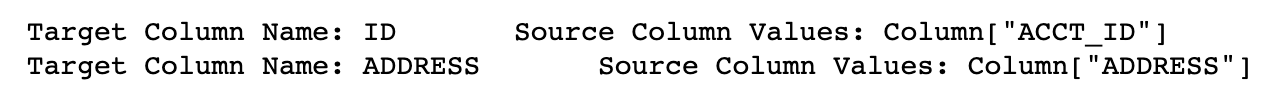


In [62]:
#Create a empty python dictionary to hold all columns and their values, 
#this dicitionary will be used to update target table.
dict_cols_to_update={} 
    
#Loop through all column names in the python list, create a dictionary thats use target column name as key 
#and source table column value as value.
for c in list_schema:
  #Take out METADATA columns, ID column and SITE_TYPE column from stm_site,
  #as those columns are not in target table and we don't need to update them.     
  if "METADATA" not in c and c!="ID" and c!="SITE_TYPE" :
        #We do this because source column STM_SITE.ACCT_ID has different name in target table DIM_ACCT.ID. 
        #We need to replace all columns has different names between source and target tables.
        if c=="ACCT_ID":
            dict_cols_to_update['ID']=df_source[c]
        else:
            #df_source[c] contains value from df_source for column c
            dict_cols_to_update[c]=df_source[c] 
            
#Print all all column names that will be updated, the first row you see here is saying we are using value 
#from source table ACCT_D to map target table column ID,which happen to the primary key of target column.
for key, value in dict_cols_to_update.items():
    print('Target Column Name:',key,'      Source Column Values:',value)

Target Column Name: ID       Source Column Values: Column["ACCT_ID"]
Target Column Name: ADDRESS       Source Column Values: Column["ADDRESS"]


## Step 5  Add target audit column LAST_UPDATE_DT to the python dictionary.

**Note:** NA

**Expected Resut:** You should see LAST_UPDATE_DT added to the dictionary.

In [59]:
#Add a new entry to dictionary, this entry is to update LAST_UPDATE_DT column using current time.
dict_cols_to_update["LAST_UPDATE_DT"]=F.current_timestamp() 

#Print all all column names that will be updated,as you can see LAST_UPDATE_DT column is added.
#and we will use current_timestamp to update only LAST_UPDATE_DT column of target table for new updates.
for key, value in dict_cols_to_update.items():
    print('Target Column Name:',key,'      Source Column Values:',value)
    


Target Column Name: ID       Source Column Values: Column["ACCT_ID"]
Target Column Name: ADDRESS       Source Column Values: Column["ADDRESS"]
Target Column Name: LAST_UPDATE_DT       Source Column Values: Column[current_timestamp]


## Step 6  Add target audit column INSERT_DT to the python dictionary.

**Note:** NA

**Expected Resut:** You should see INSERT_DT and LAST_UPDATE_DT added to the dictionary. As both columns need to be updated when perform inserts.

In [60]:
#Add a new record to a new dictionary contains all update columns, this entry is to record the update timestamp
dict_cols_to_insert= dict_cols_to_update.copy()

#Add a new column insert_dt to a dictionary contains all insert columns,
#this column is only required for inserts(not for updates).
dict_cols_to_insert["INSERT_DT"]=F.current_timestamp()  

#Print all all column names that will be inserted,as you can see INSERT_DT column is added.
#and we will use current_timestamp to update both LAST_UPDATE_DT and INSERT_DT of target table for new inserts.
for key, value in dict_cols_to_insert.items():
    print('Target Column Name:',key,'      Source Column Values:',value)

    
#Define target table in a data frame.
df_target = session.table('DIM_ACCT')     

Target Column Name: ID       Source Column Values: Column["ACCT_ID"]
Target Column Name: ADDRESS       Source Column Values: Column["ADDRESS"]
Target Column Name: LAST_UPDATE_DT       Source Column Values: Column[current_timestamp]
Target Column Name: INSERT_DT       Source Column Values: Column[current_timestamp]


## Step 7  Update target table using the python library.

**Note:** Snowflake uses merge to capture CDC changes, you can also use merge to de-duplicates, as records coming from source table will be updated based on join keysbetween source table and target table(in this case df_target['ID'] == df_source['ACCT_ID').

**Expected Resut:** Depends on what kind of CDC(insert, update, delete) you are testing, it should print out how many rows inserted, updated and deleted.

In [61]:
#Perform insert, update and delete based on requirement.
df_target.merge(df_source, df_target['ID'] == df_source['ACCT_ID'], \
                    [F.when_matched(df_source["metadata$action"]== "DELETE").delete(),\
                       F.when_matched().update(dict_cols_to_update)\
                       , F.when_not_matched().insert(dict_cols_to_insert)])

MergeResult(rows_inserted=0, rows_updated=0, rows_deleted=0)

In [ ]:
    #df_dim_acct=session.table('DIM_ACCT')
    #df_dim_acct= df_dim_acct.dropDuplicates()
    #df_dim_acct.write.mode("overwrite").save_as_table("TEMP_DIM_ACCT")
    #session.table('DIM_ACCT').drop_table()